# Layer-wise Relevance Propagation

See https://iphome.hhi.de/samek/pdf/MonXAI19.pdf

TODO: Rellenar info de cómo funciona LRP

> This notebooks gets the embeddings (or latent space) from a vultivariate time series given by an encoder (e.g. autoencoder) and uses them as input for a dimensionality reduction algorithm, to generate projections of the embeddings. (As 04.. does). Afterwards, it applies LRP to check the importance of each feature in the embeddings obtaiment. This check can be done by selecting some points in the plot and, afterwards, checking the importance for each feature in the obtainment of this part of the embedding.

## Dimensionality reduction

Generate projectsion of the embeddings

In [1]:
#Weight & Biases
import wandb

#Yaml
from yaml import load, FullLoader

#Embeddings
from dvats.all import *
from tsai.data.preparation import prepare_forecasting_data
from tsai.data.validation import get_forecasting_splits
from fastcore.all import *

#Dimensionality reduction
from tsai.imports import *

#Clustering
import hdbscan

In [2]:
check_memory_usage = True

In [3]:
if check_memory_usage:
    import nbs_pipeline.utils.memory as mem
    import torch 
    gpu_device = torch.cuda.current_device()
    mem.gpu_memory_status(gpu_device)

GPU | Used mem: 3
GPU | Used mem: 24576
GPU | Memory Usage: [--------------------] 0%


In [4]:
#Get W&B API
api = wandb.Api()

### Config parameters

Put here everything that could be needed if this notebook

TODO: Change to config.py & tml version when fixed

In [5]:
## Buscando una combinación buena
cpu_flag = False

if cpu_flag:
    n_neighbors = 15
    min_dist = 0.1
else: 
    n_neighbors = 15 #200
    min_dist = 0.1 #0.0001
    

In [6]:
config = AttrDict(
    use_wandb = False, # Whether to use or not wandb for experiment tracking
    wandb_group = None, # Whether to group this run in a wandb group
    wandb_entity = os.environ['WANDB_ENTITY'], # The entity to use for wandb,
    wandb_project = os.environ['WANDB_PROJECT'], # The project to use for wandb,
    dr_artifact_name = None, # * Set to None for using the default one (encoder validation set)
    enc_artifact = 'mi-santamaria/deepvats/mvp-SWV:latest', # Name:version of the encoder artifact
    n_neighbors = n_neighbors, #15, #UMAP
    min_dist = min_dist, #0.1, #UMAP,
    random_state = int(1234), # UMAP
    metric = 'euclidean',
    cpu = cpu_flag
)

This model needs to restore the encoder model fitted in the notebook `02x`, as well as the data and configuration

### Run DR

In [7]:
import os
path = os.path.expanduser("~/work/nbs_pipeline/")
name="04_dimensionality_reduction"
runname = name
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"

In [8]:
run_dr = wandb.init(
    entity=config.wandb_entity,
    project=config.wandb_project if config.use_wandb else 'work-nbs', 
    group=config.wandb_group,
    allow_val_change=True, 
    job_type='dimensionality_reduction', 
    mode='online' if config.use_wandb else 'disabled',
    anonymous = 'never' if config.use_wandb else 'must',
    config=config,
    resume = 'allow',
    name = runname
    #resume=False
)
config_dr = wandb.config # Object for storing hyperparameters

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find /home/macu/work/nbs_pipeline/04_dimensionality_reduction.ipynb.


In [9]:
# Botch to use artifacts offline
artifacts_gettr = run.use_artifact if config_dr.use_wandb else api.artifact

Restore the encoder model and its associated configuration

In [10]:
enc_artifact = artifacts_gettr(config.enc_artifact, type='learner')
enc_artifact.metadata

{'r': 0.71,
 'w': 900,
 'MVP': {'r': 0.71,
  'lm': 3.0,
  'crit': None,
  'sync': False,
  'fname': 'encoder_MVP',
  'dropout': 0.1,
  'verbose': False,
  'stateful': True,
  'save_best': True,
  'nan_to_num': 0,
  'custom_mask': None,
  'future_mask': False,
  'weights_path': None,
  'variable_mask': False,
  'subsequence_mask': True},
 'ref': {'hash': '-2842671438694157321',
  'type': "<class 'fastai.learner.Learner'>"},
 'freq': '4s',
 'alias': 'solar_4_seconds',
 'n_inp': 1,
 'device': 'cuda',
 'epochs': 100,
 'frozen': False,
 'mvp_ws': [450, 900],
 'stride': 450,
 'Learner': {'lr': 0.001,
  'wd': None,
  'arch': 'tsai.models.InceptionTimePlus.InceptionTimePlus',
  'moms': [0.95, 0.85, 0.95],
  'path': '.',
  '_name': '<fastai.learner.Learner object at 0x7fe2b05993c0>',
  'metrics': None,
  'opt_func': 'fastai.optimizer.Adam',
  'splitter': 'tsai.models.utils.ts_splitter',
  'train_bn': True,
  'loss_func': {'axis': -1,
   '_name': {'axis': -1,
    '_name': 'FlattenedLoss of MSELo

In [11]:
enc_artifact.name

'mvp-SWV:v53'

In [12]:
# TODO: This only works when you run it two timeS! WTF?
try:
    enc_learner = enc_artifact.to_obj()
except:
    enc_learner = enc_artifact.to_obj()

wandb:   1 of 1 files downloaded.  


Restore the dataset artifact used for training the encoder. Even if we do not compute the dimensionality reduction over this dataset, we need to know the metadata of the encoder training set, to check that 
it matches with the dataset that we want to reduce.

In [13]:
enc_logger = enc_artifact.logged_by()
enc_artifact_train = artifacts_gettr(enc_logger.config['train_artifact'], type='dataset')
if enc_logger.config['valid_artifact'] is not None:
    enc_artifact_valid = artifacts_gettr(enc_logger.config['valid_artifact'], type='dataset')
    print("enc_artifact_valid:", enc_artifact_valid.name)
print("enc_artifact_train: ", enc_artifact_train.name)

enc_artifact_train:  solar_4_seconds-20s:v3


Now we specify the dataset artifact that we want to use for the reduction. If no artifact is defined, the artifact to reduce will be the one used for validate the encoder.

In [14]:
if config_dr.dr_artifact_name is not None:
    dr_artifact = artifacts_gettr(config_dr.dr_artifact_name)
else:
    dr_artifact = enc_artifact_train
dr_artifact.name

'solar_4_seconds-20s:v3'

Now we need to check whether the artifact that is going to be used fort the dimensionality reduction matches the artifact used to train the encoder. Matching means having the same number of variables, the same window size and stride, and the same frequency.

In [15]:
df = dr_artifact.to_df()
df.head()

wandb:   1 of 1 files downloaded.  


,0,1,2,3,4
2002-01-01 00:00:00,4995.400909,3476.007487,3156.216405,1093.949562,302.794642
2002-01-01 00:00:20,3923.444920,2885.023318,2777.034856,789.073860,277.451848
2002-01-01 00:00:40,4129.310217,2733.710683,2884.988168,736.149227,301.431725
2002-01-01 00:01:00,5329.409519,2877.257957,3593.461371,780.097337,377.047302
2002-01-01 00:01:20,6150.810094,3060.637287,4012.004044,849.544364,406.177858


In [16]:
type(df)

pandas.core.frame.DataFrame

In [17]:
print(df.shape)
print(np.round(df.shape[0]/ 1e6, 1))
print(np.round(df.shape[0]/ 1e3, 1))

(46455, 5)
0.0
46.5


In [18]:
show_time_series_flag = False
if show_time_series_flag:
    # Show time series plot
    fig, ax = plt.subplots(1, figsize=(15,5), )
    cmap = matplotlib.colormaps.get_cmap('viridis')
    df.plot(color=cmap(0.05), ax=ax) # or use colormap=cmap
    # rect = Rectangle((5000, -4.2), 3000, 8.4, facecolor='lightgrey', alpha=0.5)
    # ax.add_patch(rect)
    plt.tight_layout()
    plt.legend()
    plt.show()

In [20]:
import time

In [21]:
w = enc_logger.config['w']
print(w)

900


In [22]:
if check_memory_usage: mem.gpu_memory_status(gpu_device)

GPU | Used mem: 3
GPU | Used mem: 24576
GPU | Memory Usage: [--------------------] 0%


In [23]:
t_start = time.time()
enc_input, _ = prepare_forecasting_data(df, fcst_history = w)
t_end = time.time()
t = t_end - t_start
print("SW start | " , t_start, " | end ", t_end, "total (secs): ", t)
print(enc_input.shape)

SW start |  1705932218.0609436  | end  1705932218.0617216 total (secs):  0.0007779598236083984
(45555, 5, 900)


In [24]:
if check_memory_usage: mem.gpu_memory_status(gpu_device)

GPU | Used mem: 3
GPU | Used mem: 24576
GPU | Memory Usage: [--------------------] 0%


### Getting the embeddings (activations) from the encoder

In [25]:
stride = enc_logger.config['stride']
batch_size = enc_logger.config['batch_size']

In [26]:
print(stride)
print(batch_size)

450
512


In [27]:
print(enc_input.shape)
print(enc_artifact.name)

(45555, 5, 900)
mvp-SWV:v53


In [28]:
if check_memory_usage: mem.gpu_memory_status(gpu_device)

GPU | Used mem: 3
GPU | Used mem: 24576
GPU | Memory Usage: [--------------------] 0%


In [29]:
i = 0
for a in range (enc_input.shape[0]):
    for b in range (enc_input.shape[1]):
        for c in range (enc_input.shape[2]):
            if enc_input[a,b,c] != 0: 
                print(a,b,c, enc_input[a,b,c])
                i+=1
                if i == 10: break
        if i == 10: break
    if i == 10: break

0 0 0 4995.4009088
0 0 1 3923.4449196
0 0 2 4129.3102168
0 0 3 5329.4095192
0 0 4 6150.8100944
0 0 5 6429.087605999999
0 0 6 6782.334766800001
0 0 7 6687.411101200001
0 0 8 6295.6479112
0 0 9 5356.735308400001


In [30]:
chunk_max = 10000000
shape = enc_input.shape
chunk_size_ = min(shape[1]*shape[2],chunk_max/(shape[1]*shape[2]))
N = max(3200,np.floor(chunk_size_/32))
chunk_size = N*32
chunk_size

102400

In [31]:
t_start = time.time()
embs = get_enc_embs_set_stride_set_batch_size(
    enc_input, 
    enc_learner, 
    stride = stride,
    batch_size = batch_size,
    cpu=config.cpu,
    to_numpy = True, 
    print_flag = False,
    time_flag = True,
    chunk_size = chunk_size
)
t_end = time.time()
t = t_end-t_start
print("GE start | " , t_start, " | end ", t_end, "total (secs): ", t)

get_enc_embs_set_stride_set_batch_size 2.5667176246643066 seconds
GE start |  1705932236.702389  | end  1705932239.2785392 total (secs):  2.5761501789093018


In [32]:
beep(0.05)

In [33]:
embs.shape

(102, 128)

In [34]:
embs[0,0:20]

array([1.8188119e+00, 6.6331661e-01, 3.9051659e-03, 9.4437182e-02,
       1.4863410e+00, 2.2274059e-01, 1.6778767e-03, 2.4402720e-01,
       2.8789997e-02, 8.2015598e-01, 9.6769774e-01, 8.3241403e-01,
       2.9818532e+00, 1.7842115e-01, 6.5414035e-01, 9.3766838e-02,
       9.0107924e-01, 2.6088694e-01, 2.2802889e-01, 1.8982853e+00],
      dtype=float32)

In [35]:
t_end = time.time()
t = t_end-t_start
print("GE start | " , t_start, " | end (next cell) ", t_end, "total (secs): ", t)

GE start |  1705932236.702389  | end (next cell)  1705932248.9540818 total (secs):  12.251692771911621


In [36]:
if check_memory_usage: mem.gpu_memory_status(gpu_device)

GPU | Used mem: 3
GPU | Used mem: 24576
GPU | Memory Usage: [--------------------] 0%


In [37]:
run_dr.finish()

In [255]:
#Restart kernel (Debugging code 4 analysing where can app be failing. Expecting to be related to GPU mem ussage)
#os._exit(00)

### Dimensions check

In [38]:
print(embs.shape)
print(enc_input.shape)

(102, 128)
(45555, 5, 900)


In [39]:
embs[0][:10]

array([1.8188119e+00, 6.6331661e-01, 3.9051659e-03, 9.4437182e-02,
       1.4863410e+00, 2.2274059e-01, 1.6778767e-03, 2.4402720e-01,
       2.8789997e-02, 8.2015598e-01], dtype=float32)

In [40]:
#Dimensions check
num_inputs = np.ceil(enc_input.shape[0]/stride)
num_embs = embs.shape[0]
test_eq(num_inputs, num_embs )
print(num_inputs, num_embs)

102.0 102


Average embeddings in the time dimension, if needed

## Dimensionality reduction using UMAP

We use DR techniques to provide an alternative view for users to visually analyze and explore the time-series data. The algorithm UMAP shows its high competitiveness compared to t-SNE. t-SNE suffers from some limitations such as loss of large-scale information (the inter-cluster relationships). UMAP has a faster runtime and provides better scaling which helps to gain a meaningful organization of clusters, outliers and the preservation of continuums compared to t-SNE

For this part of the implementation, the package [umap-learn](https://github.com/lmcinnes/umap) is used. The input of the algoritm is the $n \times \delta$ that contains, for each slice of the time series, the corresponding $\delta$ latent embeddings given by the encoder.

The hyperparameters of UMAP are given values by default here. If the value has been already set previously, that means this notebook is being called from a wandb sweep, and we must use the value that the sweep is bringing.

In [41]:
if cpu_flag:
    umap_params = {
        'n_neighbors' : config_dr.n_neighbors,
        'min_dist' : config_dr.min_dist,
        'random_state': np.uint64(1234), 
        'metric': config_dr.metric,
        'a': 1.5769434601962196,
        'b': 0.8950608779914887,
        #'metric_kwds': {'p': 2}, #No debería ser necesario, just in case
        'output_metric': 'euclidean',
        'verbose': 4,
        'n_epochs': 200
    }
else:
    umap_params = {
        'n_neighbors' : config_dr.n_neighbors,
        'min_dist' : config_dr.min_dist,
        'random_state': np.uint64(1234), 
        'metric': config_dr.metric,
        'a': 1.5769434601962196,
        'b': 0.8950608779914887,
        'target_metric': 'euclidean',
        'target_n_neighbors': config_dr.n_neighbors,
        'verbose': 6,
        'n_epochs': 200
    }






check_reducer = True
import utils.config as cfg_
if check_reducer:
    import umap
    import cuml
    print("-- umap.UMAP --", cpu_flag)
    reducer1 = umap.UMAP(force_approximation_algorithm = True, **umap_params)
    print("-- cuml.UMAP --", cpu_flag)
    reducer2 = cuml.UMAP(**umap_params)
    print("------- reducer1 --------")
    print(reducer1)
    params1=AttrDict(reducer1.get_params())
    print("------- reducer2 --------")
    print(reducer2)
    params2=AttrDict(reducer2.get_params())
    print("------- reducer2 --------")
    cfg_.diff_attrdict(dict_original=params2, dict_modified=params1, both=True)
    beep(0.10)

#if not cpu_flag:
    #umap_params['force_approximation_algorithm'] = True # Este no parece ser el influencer
    #umap_params['angular_rp_forest'] = True #No es el influencer

#if params2['random_state'] != 1234:
 #   raise Exception("Wrong random_state params")

-- umap.UMAP -- False
-- cuml.UMAP -- False
------- reducer1 --------
UMAP(a=1.5769434601962196, b=0.8950608779914887, force_approximation_algorithm=True, n_epochs=200, random_state=1234, target_metric='euclidean', target_n_neighbors=15, verbose=6)
------- reducer2 --------
UMAP()
------- reducer2 --------
unique is missing in original dict | False 
n_neighbors: 15
repulsion_strength: 1.0
target_weight: 0.5
random_state: 1234
output_dens is missing in original dict | False 
metric_kwds: None
dens_var_shift is missing in original dict | 0.1 
tqdm_kwds is missing in original dict | None 
set_op_mix_ratio: 1.0
local_connectivity: 1.0
spread: 1.0
dens_frac is missing in original dict | 0.3 
angular_rp_forest is missing in original dict | False 
callback is missing in modified dict | 0 
b: 0.8950608779914887
output_type is missing in modified dict | 0 
disconnection_distance is missing in original dict | None 
transform_queue_size: 4.0
metric: euclidean
low_memory is missing in original dic

In [42]:
#Ensure no nan ((Intento de Macu. La celda de comentada abajo es la original. Pero falla por Nan con sunspot))
embs_no_nan = embs[~np.isnan(embs).any(axis=1)]
embs_no_nan.shape

(101, 128)

In [43]:
umap_params_cpu = {
        'n_neighbors' : config_dr.n_neighbors,
        'min_dist' : config_dr.min_dist,
        'random_state': np.uint64(1234), 
        'metric': config_dr.metric,
        #'a': 1.5769434601962196,
        #'b': 0.8950608779914887,
        #'metric_kwds': {'p': 2}, #No debería ser necesario, just in case
        #'output_metric': 'euclidean',
        'verbose': 4,
        #'n_epochs': 200
    }
umap_params_gpu = {
        'n_neighbors' : config_dr.n_neighbors,
        'min_dist' : config_dr.min_dist,
        'random_state': np.uint64(1234), 
        'metric': config_dr.metric,
        'a': 1.5769434601962196,
        'b': 0.8950608779914887,
        'target_metric': 'euclidean',
        'target_n_neighbors': config_dr.n_neighbors,
        'verbose': 4, #6, #CUML_LEVEL_TRACE
        'n_epochs': 200*3*2,
        'init': 'random',
        'hash_input': True
    }


if cpu_flag:
    umap_params = umap_params_cpu
else:
    umap_params = umap_params_gpu

umap_params


{'n_neighbors': 15,
 'min_dist': 0.1,
 'random_state': 1234,
 'metric': 'euclidean',
 'a': 1.5769434601962196,
 'b': 0.8950608779914887,
 'target_metric': 'euclidean',
 'target_n_neighbors': 15,
 'verbose': 4,
 'n_epochs': 1200,
 'init': 'random',
 'hash_input': True}

In [44]:
embs_no_nan.shape

(101, 128)

In [45]:
prjs_pca = get_PCA_prjs(
    X = embs_no_nan, 
    cpu = cpu_flag, #config_dr.cpu, 
    print_flag = True, 
    #target_weight=1,
    **umap_params
)
prjs_pca.shape

[I] [14:04:41.071976] Unused keyword parameter: print_flag during cuML estimator initialization
[I] [14:04:41.075870] Unused keyword parameter: n_neighbors during cuML estimator initialization
[I] [14:04:41.076448] Unused keyword parameter: min_dist during cuML estimator initialization
[I] [14:04:41.076784] Unused keyword parameter: metric during cuML estimator initialization
[I] [14:04:41.076972] Unused keyword parameter: a during cuML estimator initialization
[I] [14:04:41.077158] Unused keyword parameter: b during cuML estimator initialization
[I] [14:04:41.077345] Unused keyword parameter: target_metric during cuML estimator initialization
[I] [14:04:41.077527] Unused keyword parameter: target_n_neighbors during cuML estimator initialization
[I] [14:04:41.077704] Unused keyword parameter: n_epochs during cuML estimator initialization
[I] [14:04:41.077885] Unused keyword parameter: init during cuML estimator initialization
[I] [14:04:41.078063] Unused keyword parameter: hash_input d

(101, 101)

In [46]:
prjs_umap = get_UMAP_prjs(
    input_data = prjs_pca, 
    cpu = cpu_flag, #config_dr.cpu, 
    print_flag = True, 
    #target_weight=1,
    **umap_params
)
prjs_umap.shape

--> get_UMAP_prjs
kwargs:  {'n_neighbors': 15, 'min_dist': 0.1, 'random_state': 1234, 'metric': 'euclidean', 'a': 1.5769434601962196, 'b': 0.8950608779914887, 'target_metric': 'euclidean', 'target_n_neighbors': 15, 'verbose': 4, 'n_epochs': 1200, 'init': 'random', 'hash_input': True}
3a598f1b2c8266158d4ef1b846da6223
GPU | Used mem: 3
GPU | Used mem: 24576
GPU | Memory Usage: [--------------------] 0%
-- cuml.UMAP -- False
------- reducer --------
UMAP()
{'handle': <pylibraft.common.handle.Handle object at 0x7fdf4d549ce0>, 'verbose': 4, 'output_type': 'input', 'n_neighbors': 15, 'n_components': 2, 'n_epochs': 1200, 'learning_rate': 1.0, 'min_dist': 0.1, 'spread': 1.0, 'set_op_mix_ratio': 1.0, 'local_connectivity': 1.0, 'repulsion_strength': 1.0, 'negative_sample_rate': 5, 'transform_queue_size': 4.0, 'init': 'random', 'a': 1.5769434601962196, 'b': 0.8950608779914887, 'target_n_neighbors': 15, 'target_weight': 0.5, 'target_metric': 'euclidean', 'hash_input': True, 'random_state': 1234, '

(101, 2)

In [47]:
beep(0.15)
beep(0.15)
beep(0.15)


In [266]:
prjs_umap[0:10] # En R head(res[1,],10)

array([[-9.571686 ,  2.8597803],
       [-9.698978 ,  2.7347527],
       [-1.9509916,  4.013047 ],
       [ 2.9112139,  3.1223269],
       [-1.7193642,  4.128701 ],
       [-9.209486 ,  2.6853466],
       [-9.673599 ,  2.715004 ],
       [-7.9055843,  2.3767052],
       [-7.646614 ,  2.6027994],
       [-9.029512 ,  2.7336407]], dtype=float32)

In [267]:
#prjs = get_UMAP_prjs(embs, cpu=False, **umap_params)
#prjs.shape

Save the projections as an artifact

In [48]:
if config.use_wandb: 
    run.log_artifact(ReferenceArtifact(prjs, 'projections', type='projections', 
metadata=dict(run_dr.config)), aliases=f'run-{run.project}-{run.id}')

## Create Precomputed Clusters

In order to integrate precomputed clusters into the embedding space, it's necessary to log artifacts that include the labels of the newly created clusters. 

The cluster creation process is presented below. This creation procedure can be modified according to specific needs. However, the structure of the new artifact must be preserved (it must be a numpy.ndarray and the number of elements must be equal to the number of points in the embedding space).

In [49]:
print(f'HDBSCAN supported metrics: {list(hdbscan.dist_metrics.METRIC_MAPPING.keys())}')

HDBSCAN supported metrics: ['euclidean', 'l2', 'minkowski', 'p', 'manhattan', 'cityblock', 'l1', 'chebyshev', 'infinity', 'seuclidean', 'mahalanobis', 'wminkowski', 'hamming', 'canberra', 'braycurtis', 'matching', 'jaccard', 'dice', 'kulsinski', 'rogerstanimoto', 'russellrao', 'sokalmichener', 'sokalsneath', 'haversine', 'cosine', 'arccos', 'pyfunc']


In [50]:
# Define HDBSCAN parameters
hdbscan_kwargs = {
    'min_cluster_size' : 7, #100, #100,
    'min_samples' : 3,
    'cluster_selection_epsilon' : 0.0001,
}
metric_kwargs = {
    'metric' : 'euclidean' #'jaccard'
}

In [51]:
# Create clusters using HDBSCAN
clusters = hdbscan.HDBSCAN(**hdbscan_kwargs, **metric_kwargs).fit(prjs_umap)
clusters_labels = clusters.labels_
list(Counter(clusters_labels).items())

[(0, 77), (2, 8), (1, 16)]

### Check cluster score

In [52]:
score = cluster_score(prjs_umap, clusters_labels, True)

Silhouette_score: 0.33987626


In [53]:
# Testing artifact structure 
test_eq_type(type(clusters_labels), np.ndarray)
test_eq(clusters_labels.size, prjs_umap.shape[0])

In [54]:
# Create and log 'clusters_labels' artifact
clusters_ar = ReferenceArtifact(obj=clusters_labels, name='clusters_labels')
clusters_ar.metadata, clusters_ar.manifest.entries.values()

({'ref': {'hash': '2948562522684941156', 'type': "<class 'numpy.ndarray'>"}},
 dict_values([ArtifactManifestEntry(path='2948562522684941156', digest='uiL3rMhAv4OaCkYwXOvbKg==', ref='file:///home/macu/data/wandb_artifacts/2948562522684941156', birth_artifact_id=None, size=958, extra={}, local_path=None)]))

In [55]:
run_dr.log_artifact(clusters_ar, aliases=['hdbscan_jaccard'])

## 2D Visualization 

While the connected scatter plot is a simple visualization technique, it has very specific functions in our approach. Every sliding window is represented as a dot in the plot after the projection process (Fig. 4C, D of the paper). Before labeling, all points have the same color and transparency, and when they are concentrated in one area, the densities are accumulated. Lines are used to connect consecutive points preserving the temporal ordering of the data and allowing the user to see temporal connections (Fig. 4B of the paper). Thus, the point is linked to the previous point (inner) and to the posterior point (outer) as an indication of the flow of time.

In [56]:
#| export
def plot_projections(prjs, umap_params, fig_size = (25,25)):
    "Plot 2D projections thorugh a connected scatter plot"
    df_prjs = pd.DataFrame(prjs, columns = ['x1', 'x2'])
    fig = plt.figure(figsize=(fig_size[0],fig_size[1]))
    ax = fig.add_subplot(111)
    ax.scatter(df_prjs['x1'], df_prjs['x2'], marker='o', facecolors='none', edgecolors='b', alpha=0.1)
    ax.plot(df_prjs['x1'], df_prjs['x2'], alpha=0.5, picker=1)
    plt.title('DR params -  n_neighbors:{:d} min_dist:{:f}'.format(
        umap_params['n_neighbors'],umap_params['min_dist']))
    return ax

In [57]:
#| export
def plot_projections_clusters(prjs, clusters_labels, umap_params, fig_size = (25,25)):
    "Plot 2D projections thorugh a connected scatter plot"
    df_prjs = pd.DataFrame(prjs, columns = ['x1', 'x2'])
    df_prjs['cluster'] = clusters_labels
    
    fig = plt.figure(figsize=(fig_size[0],fig_size[1]))
    ax = fig.add_subplot(111)
    
    # Create a scatter plot for each cluster with different colors
    unique_labels = df_prjs['cluster'].unique()
    print(unique_labels)
    for label in unique_labels:
        cluster_data = df_prjs[df_prjs['cluster'] == label]
        ax.scatter(cluster_data['x1'], cluster_data['x2'], label=f'Cluster {label}')
        #ax.scatter(df_prjs['x1'], df_prjs['x2'], marker='o', facecolors='none', edgecolors='b', alpha=0.1)
    
    #ax.plot(df_prjs['x1'], df_prjs['x2'], alpha=0.5, picker=1)
    plt.title('DR params -  n_neighbors:{:d} min_dist:{:f}'.format(
        umap_params['n_neighbors'],umap_params['min_dist']))
    return ax

[0 2 1]


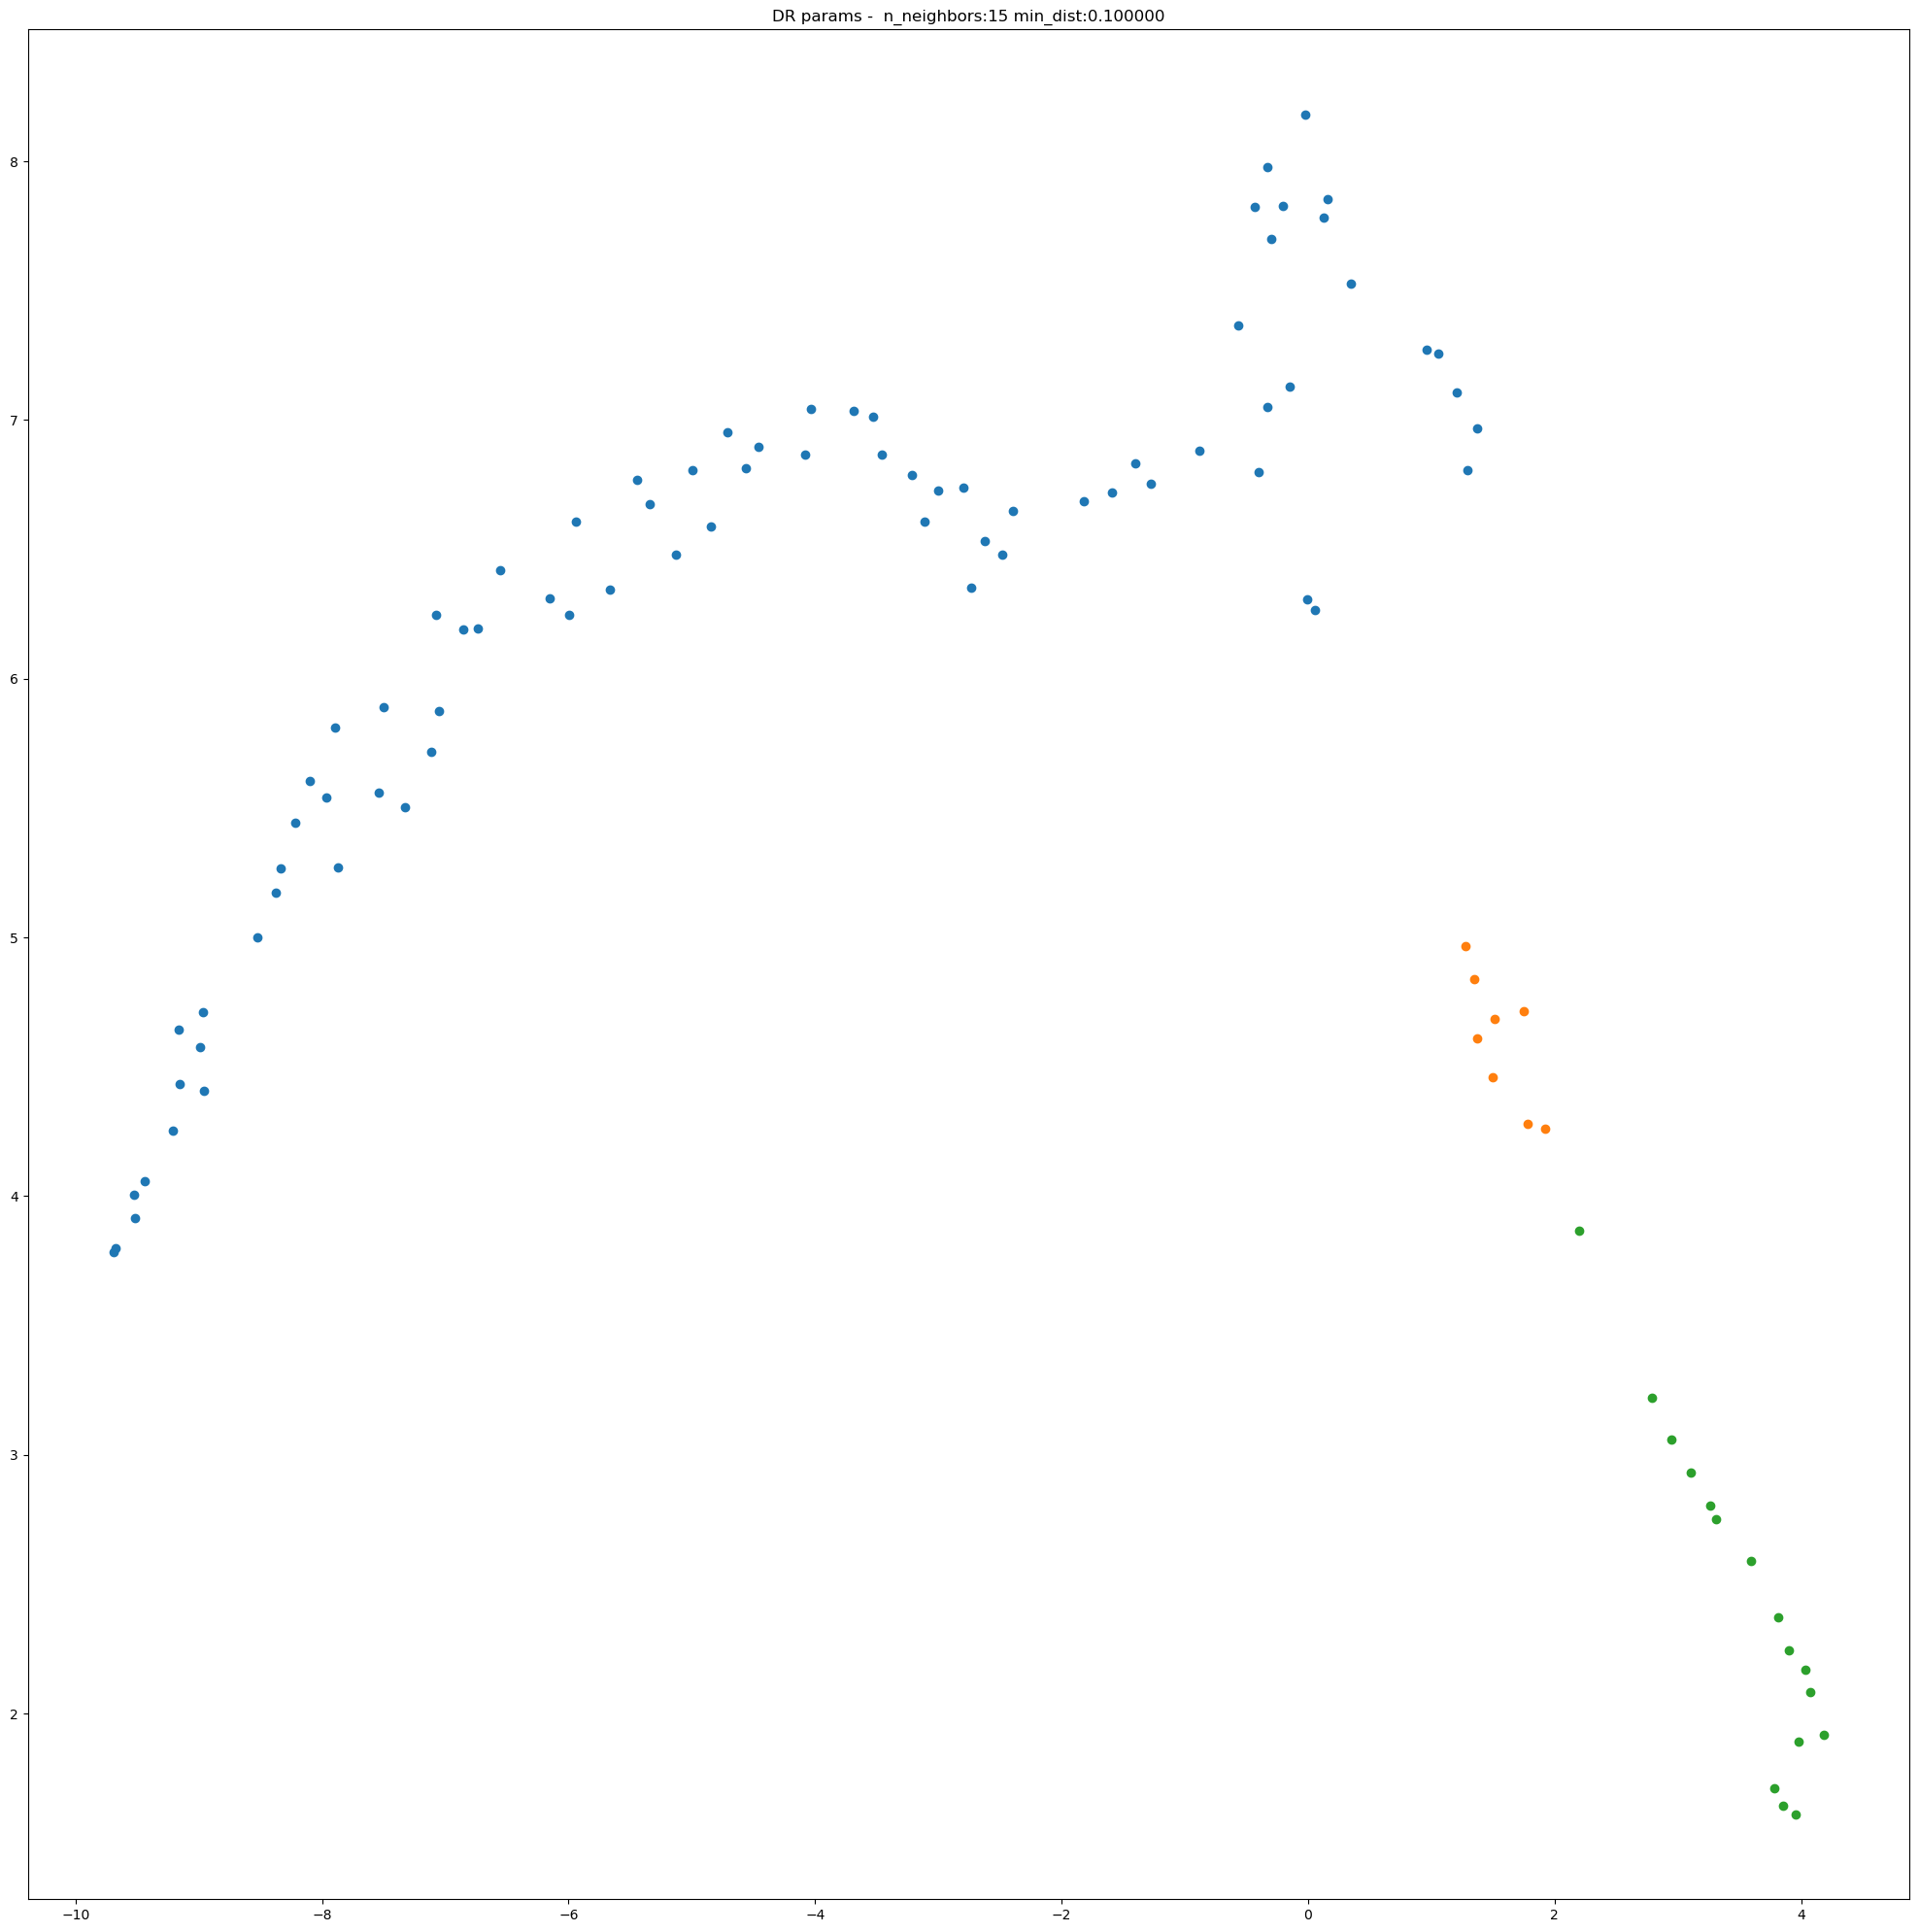

In [58]:
prjs_plt = plot_projections_clusters(prjs_umap, clusters_labels, umap_params)

In [60]:
beep(0.25)
beep(0.25)
beep(0.25)

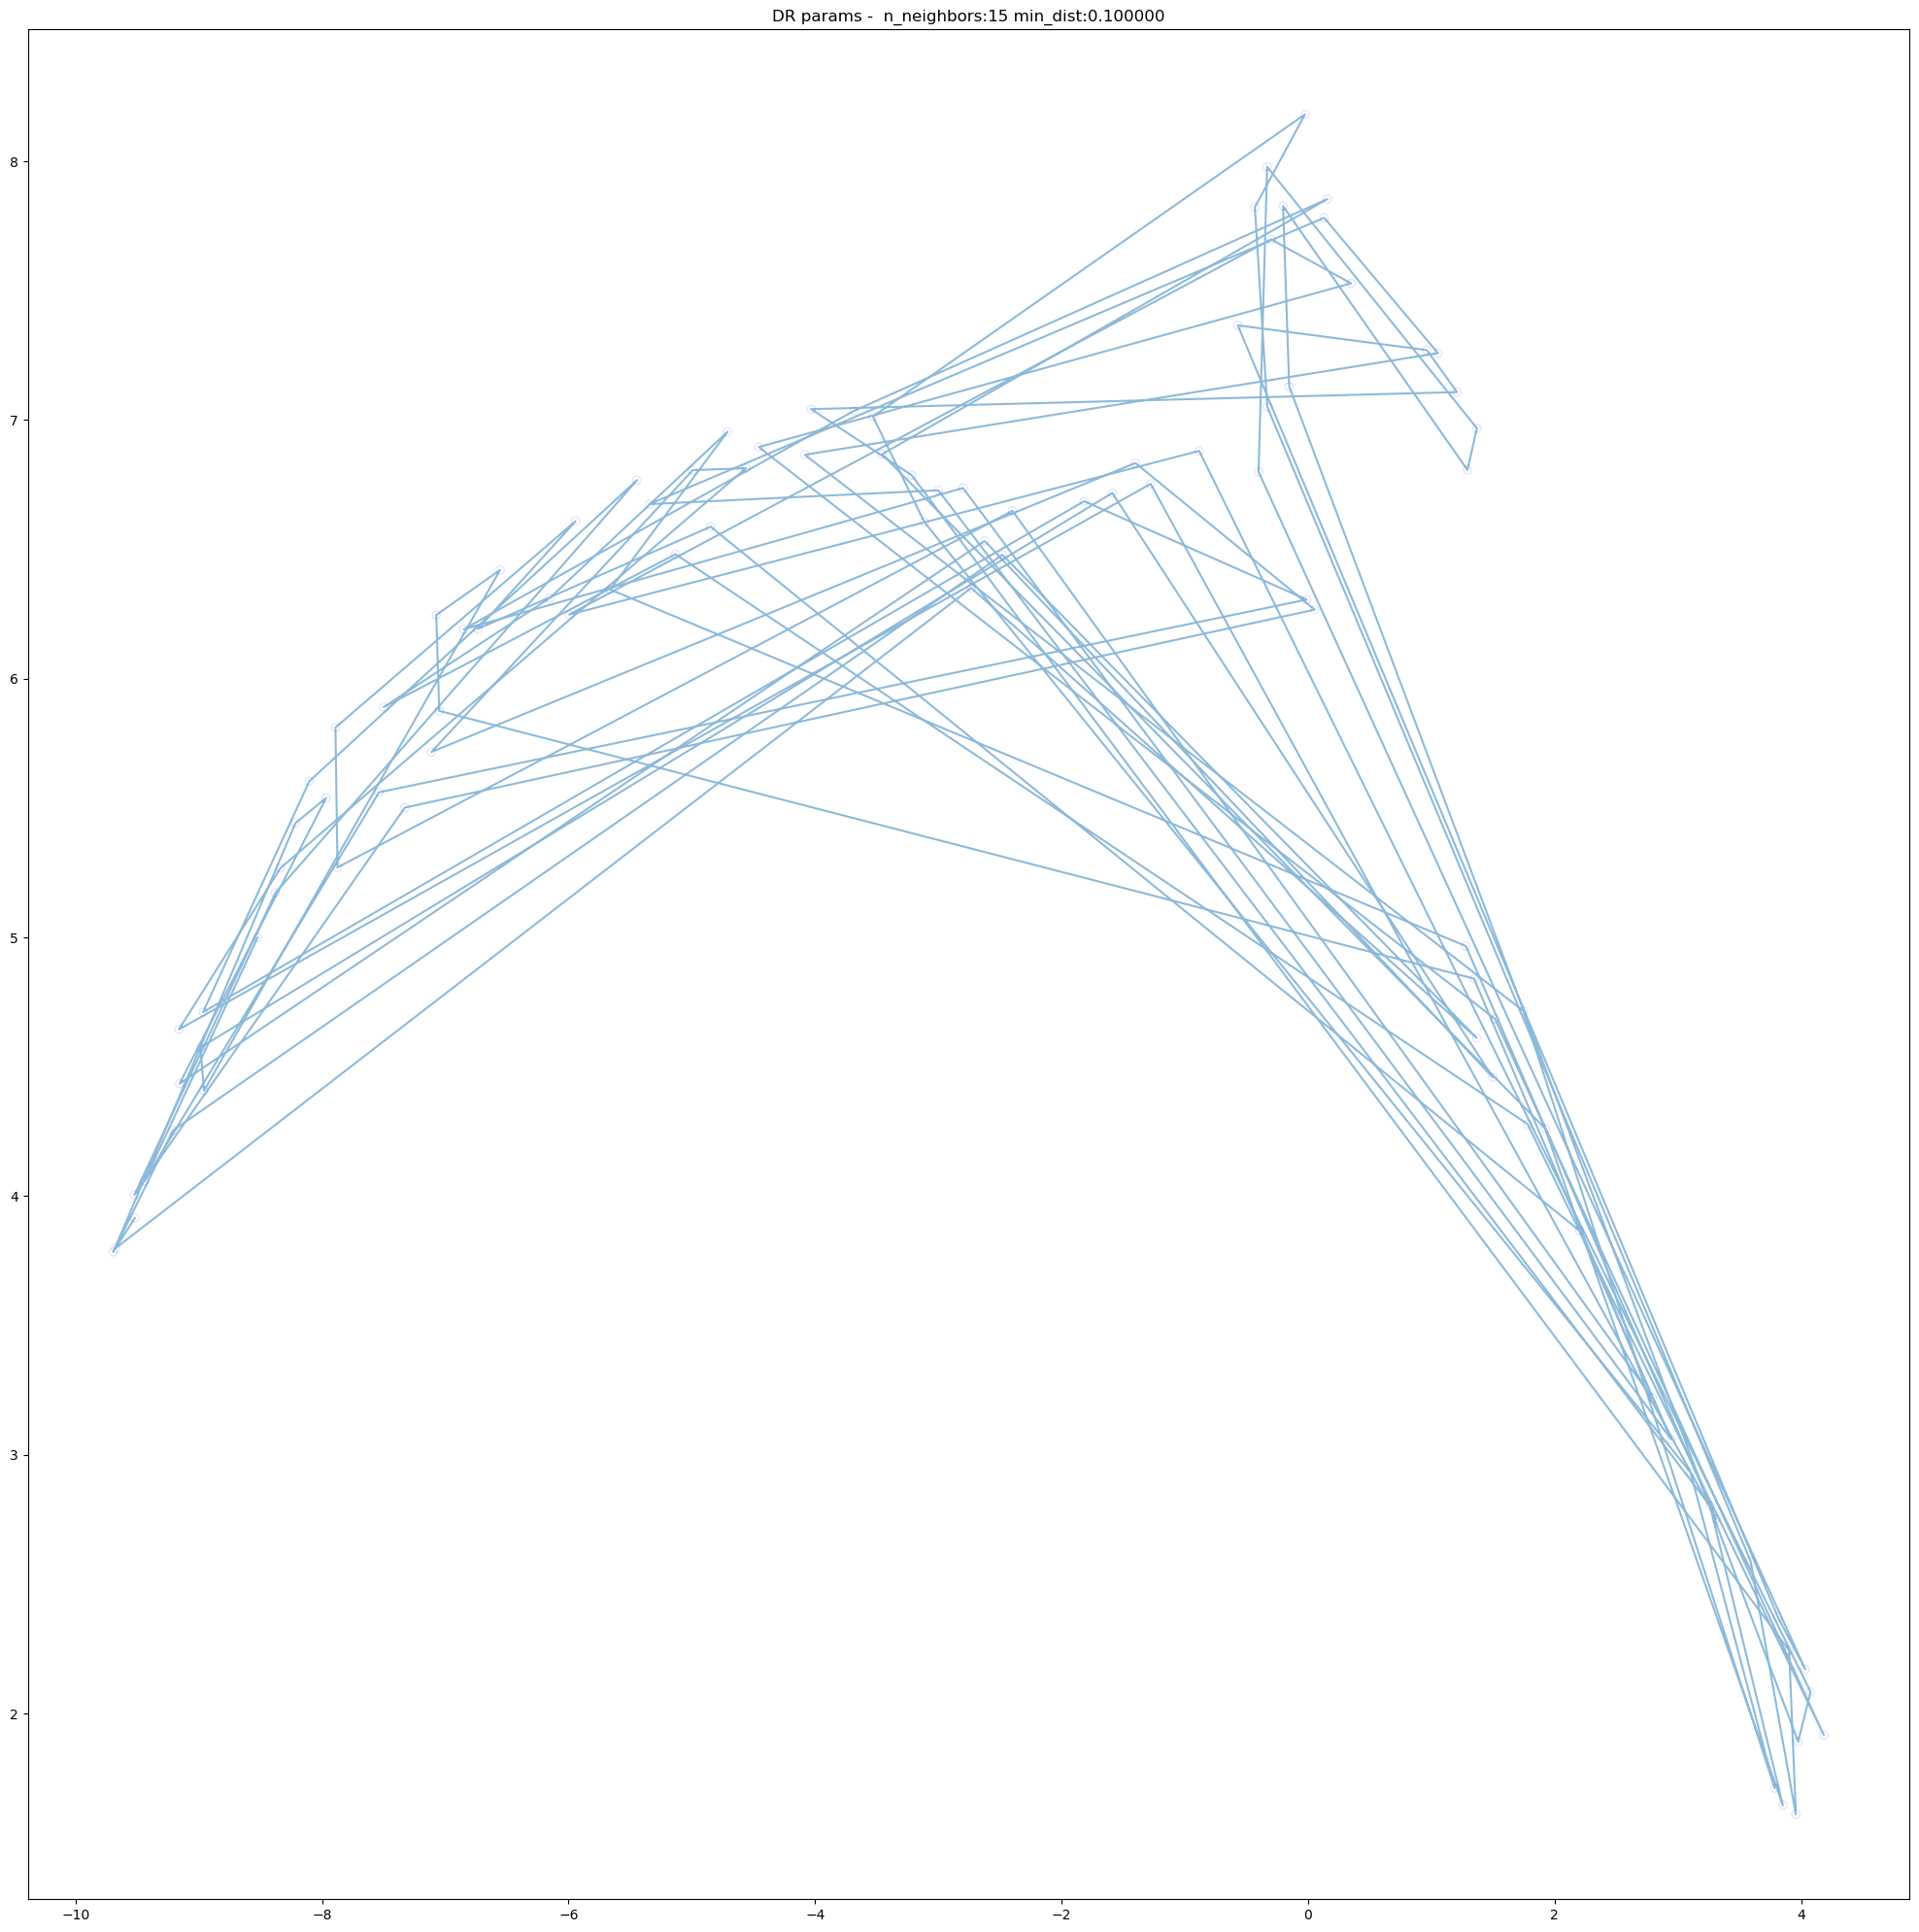

In [61]:
prjs_plt = plot_projections(prjs_umap, umap_params)

Log this plot as part of the current wandb run

In [62]:
#| hide

# Get the figure of the embedding plot, and save it on thea wandb run.
run_dr.log({"img": [wandb.Image(prjs_plt.get_figure(), caption="dr_projections_plot")]})

#run_dr.log({'embeddings_plot': embeddings_plot})

In [63]:
#| hide
run_dr.finish()

## Anomalies simple detector: dynamic plot for determining whether a window of time series is anomalous

#### Get Anomaly Score

In [64]:
# Create clusters using HDBSCAN
clusters = hdbscan.HDBSCAN(**hdbscan_kwargs, **metric_kwargs).fit(prjs_umap)
clusters_labels = clusters.labels_
list(Counter(clusters_labels).items())

[(0, 77), (2, 8), (1, 16)]

In [65]:
def calculate_cluster_stats(data, labels):
    """Computes the media and the standard deviation for every cluster."""
    cluster_stats = {}
    for label in np.unique(labels):
        #members = data[labels == label]
        members = data
        mean = np.mean(members, axis = 0)
        std = np.std(members, axis = 0)
        cluster_stats[label] = (mean, std)
    return cluster_stats

In [66]:
def anomaly_score(point, cluster_stats, label):
    """Computes an anomaly score for each point."""
    mean, std = cluster_stats[label]
    return np.linalg.norm((point - mean) / std)

In [67]:
def detector(data, labels):
    """Anomaly detection function."""
    cluster_stats = calculate_cluster_stats(data, labels)
    scores = []
    for point, label in zip(data, labels):
        score = anomaly_score(point, cluster_stats, label)
        scores.append(score)
    return np.array(scores)

In [68]:
anomaly_scores = detector(prjs_umap, clusters_labels)

### Check anomaly scores distribution

In [69]:
def plot_anomaly_scores_distribution(anomaly_scores):
    "Plot the distribution of anomaly scores to check for normality"
    plt.figure(figsize=(10, 6))
    sns.histplot(anomaly_scores, kde=True, bins=30)
    plt.title("Distribución de Anomaly Scores")
    plt.xlabel("Anomaly Score")
    plt.ylabel("Frecuencia")
    plt.show()

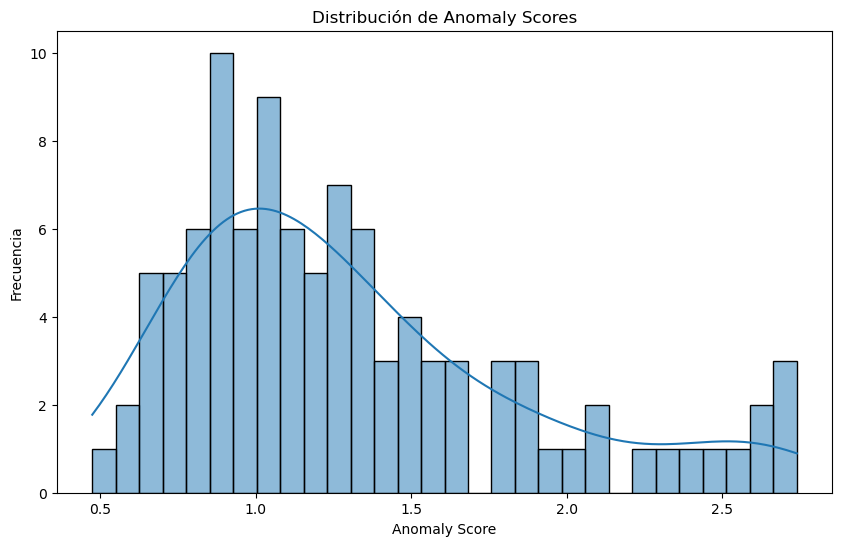

In [70]:
import seaborn as sns
plot_anomaly_scores_distribution(anomaly_scores)

## Select a threshold

In [72]:
print(anomaly_scores.shape)
print("min ", np.min(anomaly_scores))
print("max ", np.max(anomaly_scores))
anomaly_scores_mean = np.mean(anomaly_scores)
print("media ", anomaly_scores_mean)
anomaly_scores_std = np.std(anomaly_scores)
print("std ", anomaly_scores_std)

(101,)
min  0.4749713
max  2.7393992
media  1.3038574
std  0.54768246


In [73]:
num_std = 2
threshold = anomaly_scores_mean + num_std * anomaly_scores_std
print("Threshold: ", threshold)

Threshold:  2.3992223739624023


### Plot the anomalies

In [74]:
#| export
def plot_clusters_with_anomalies(prjs, clusters_labels, anomaly_scores, threshold, fig_size=(25, 25)):
    "Plot 2D projections of clusters and superimpose anomalies"
    df_prjs = pd.DataFrame(prjs, columns=['x1', 'x2'])
    df_prjs['cluster'] = clusters_labels
    df_prjs['anomaly'] = anomaly_scores > threshold

    fig = plt.figure(figsize=(fig_size[0], fig_size[1]))
    ax = fig.add_subplot(111)

    # Plot each cluster with different colors
    unique_labels = df_prjs['cluster'].unique()
    for label in unique_labels:
        cluster_data = df_prjs[df_prjs['cluster'] == label]
        ax.scatter(cluster_data['x1'], cluster_data['x2'], label=f'Cluster {label}', alpha=0.7)

    # Superimpose anomalies
    anomalies = df_prjs[df_prjs['anomaly']]
    ax.scatter(anomalies['x1'], anomalies['x2'], color='red', label='Anomalies', edgecolor='k', s=50)

    plt.title('Clusters and anomalies')
    plt.legend()
    plt.show()


In [75]:
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
from functools import partial
fig_size = (7,7)
def update_plot(threshold):
    plot_clusters_with_anomalies(prjs_umap, clusters_labels, anomaly_scores, threshold, fig_size)

In [76]:
threshold_slider = widgets.FloatSlider(value=2, min=1, max=3, step=0.01, description='Threshold')
widgets.interactive(update_plot, threshold=threshold_slider)

interactive(children=(FloatSlider(value=2.0, description='Threshold', max=3.0, min=1.0, step=0.01), Output()),…

#### Using quartiles for the scores

In [77]:
def detect_anomalies_using_iqr(scores):
    # First and third quartiles
    Q1 = np.percentile(scores, 25)
    Q3 = np.percentile(scores, 75)
    # IQR range
    IQR = Q3 - Q1
    
    #Limits for anomalies
    factor = 1.5
    lower_bound = Q1 - (factor * IQR)
    upper_bound = Q3 + (factor * IQR)
    
    # Get anomalies
    anomalies = (scores < lower_bound) | (scores > upper_bound)
    
    return anomalies, lower_bound, upper_bound

In [78]:
anomalies, lower_bound, upper_bound = detect_anomalies_using_iqr(anomaly_scores)

print("Lower Bound for Anomalies:", lower_bound)
print("Upper Bound for Anomalies:", upper_bound)

Lower Bound for Anomalies: -0.06816497445106506
Upper Bound for Anomalies: 2.518148511648178


In [79]:
def plot_data_with_anomalies(data, anomalies):
    plt.scatter(data[:, 0], data[:, 1], color='blue', label='Normal Data')
    plt.scatter(data[anomalies, 0], data[anomalies, 1], color='red', label='Anomalies')
    plt.title('Data with Anomalies highlighted')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

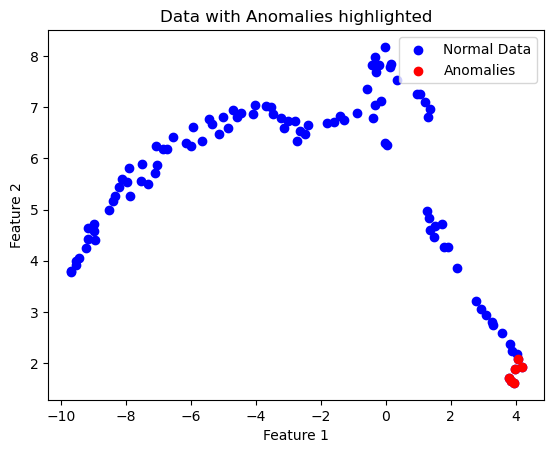

In [80]:
plot_data_with_anomalies(prjs_umap, anomalies)

## LRP

In [87]:
print("Execution ended")
beep(1)

Execution ended


In [88]:
#Restart kernel (Debugging code 4 analysing where can app be failing. Expecting to be related to GPU mem ussage)
#os._exit(00)